## The motivation for this python notebook is to test the Taylor expansion of the classical MSMF versus the basis decomposition done in DDFacet for MF, as I understand it...

## 1) Source simulation

Simulating the spectrum of a extragalactic source with $\alpha$=-0.7 and some $\beta$.

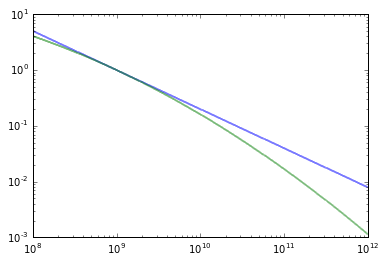

In [1]:
import numpy as np
import scipy.constants as sc
import scipy.interpolate as si
import matplotlib.pyplot as plt
%matplotlib inline

alpha=-0.7   # Spectral Index
beta=-0.0933   # Spectral Curvature
I0=1.
nu0=1e9
lambda0=sc.c/nu0


Nfreq=1000

freqstart=8
freqend=12

freq=np.logspace(freqstart,freqend,Nfreq)

spectrum=I0*(freq/nu0)**(alpha)  # alpha only
spectrum2=I0*(freq/nu0)**(alpha+beta*np.log10(freq/nu0))  # alpha and beta

plt.loglog(freq,spectrum,".",ms=0.5)
plt.loglog(freq,spectrum2,".",ms=0.5)


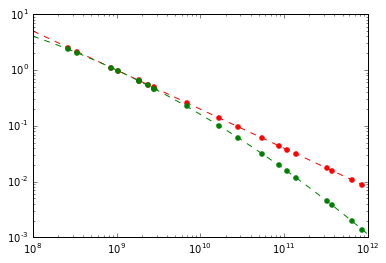

In [2]:
# prepare some samples of spectrum
Nsamples=20

randomindices=(np.random.rand(Nsamples)*1000).astype(int)
randomindices
sampledfreq=freq[randomindices]
sampledspectrum=spectrum[randomindices]   # sampled spectrum (alpha)
sampledspectrum2=spectrum2[randomindices]  # sampled spectrum (alpha,beta)

plt.loglog(freq,spectrum,"r--",ms=0.5)
plt.loglog(sampledfreq,sampledspectrum,"r.",ms=10)
plt.loglog(freq,spectrum2,"g--",ms=0.5)
plt.loglog(sampledfreq,sampledspectrum2,"g.",ms=10)


## 2) Polynomial fit

##### Full dataset

In [3]:
coefs = np.polynomial.polynomial.polyfit(np.log10(freq/nu0), np.log10(spectrum), 2)
print "Alpha = "+str(coefs[1])

Alpha = -0.7


In [4]:
coefs2 = np.polynomial.polynomial.polyfit(np.log10(freq/nu0), np.log10(spectrum2), 2)
print "Alpha = "+str(coefs2[1])
print "Beta = "+str(coefs2[2])

Alpha = -0.7
Beta = -0.0933


##### sampled dataset

In [5]:
coefs = np.polynomial.polynomial.polyfit(np.log10(sampledfreq/nu0), np.log10(sampledspectrum), 2)
print "Alpha = "+str(coefs[1])

Alpha = -0.7


In [6]:
coefs2 = np.polynomial.polynomial.polyfit(np.log10(sampledfreq/nu0), np.log10(sampledspectrum2), 2)
print "Alpha = "+str(coefs2[1])
print "Beta = "+str(coefs2[2])

Alpha = -0.7
Beta = -0.0933


## 3) Cyril Expansion

Decomposition on a basis of $(\frac{\nu}{\nu_0})^{\alpha_i}$ given a predefined set of $\alpha_i$. 

$I_i$ are weights of each basis vector but not physical intensities. 

$\alpha_i$ are power law indices but not the physical $\alpha$.

$I_i$ are determined after some fit (using curve_fit here, I do not know how it is performed in DDFacet).

At any given frequency, the flux density of a source is defined as the weighted sum of all *fake* spectra.
$$ F(\nu)=\sum\limits_{i=0}^{N_{\alpha}}I_i(\frac{\nu}{\nu_0})^{\alpha_i}$$


### Definition of the expansion function and wrapper for curve_fit
The wrapper allow to fit for a subset of parameters while maintaining the other parameters fixed (alpha, nu0)

In [7]:
from scipy.optimize import curve_fit

def CTpoly(coefs,alphas,nu0,nu):
    Nalphas=len(alphas)
    fluxdensity=0.
    for i,alphai in enumerate(alphas):
        tmp=coefs[0][i]*(nu*1./nu0)**(alphai)
        fluxdensity+=tmp
    
    return fluxdensity


def wrapper_CTpoly(nu,alphas,nu0,*coefs): # to be able to fit only for the coefs given a fixed set of alphas and nu0
    #print coefs
    return CTpoly(coefs,alphas,nu0,nu)
    

##### Fitting the full data
Giving alpha's as a fixed basis.
coefs are initialized to 0
nu0 is fixed

In [8]:
alphas=np.array([-2.,-1.5,-1.,-0.5,0.,0.5,1.,1.5,2.])
coefs0=alphas*0

# on the whole spectrum
x=freq
y=spectrum2
print len(x)
# perform the fits
popt, pcov = curve_fit(lambda nu, *coefs0: wrapper_CTpoly(nu,alphas,nu0,coefs0), x, y, p0=coefs0)

1000


##### Fitting the sampled data
Giving alpha's as a fixed basis.
coefs are initialized to 0
nu0 is fixed

In [9]:
alphas=np.array([-2.,-1.5,-1.,-0.5,0.,0.5,1.,1.5,2.])
coefs0=alphas*0

# on the sampled spectrum
x=sampledfreq
y=sampledspectrum2
print len(x)
# perform the fits
popt2, pcov2 = curve_fit(lambda nu, *coefs0: wrapper_CTpoly(nu,alphas,nu0,coefs0), x, y, p0=coefs0)

20


##### Inspecting the fit results
Giving the values of the coefs $I_i$ corresponding to each $\alpha_i$.
Plotting the covariance matrix to show goodness of fit.

In [10]:
fitcoefs=[popt] # to be compatible with the structure of coefs in CTpoly
fitcoefs2=[popt2]
fitcoefs,fitcoefs2

([array([  1.83833248e-02,  -1.63787526e-01,   4.88353773e-01,
           8.65409476e-01,  -2.40684560e-01,   3.29759802e-02,
          -2.26625033e-03,   7.34416502e-05,  -8.88912340e-07])],
 [array([  5.29568951e-02,  -3.42089062e-01,   8.16377878e-01,
           6.00938618e-01,  -1.44006033e-01,   1.69438403e-02,
          -1.03790198e-03,   3.10853664e-05,  -3.57470638e-07])])

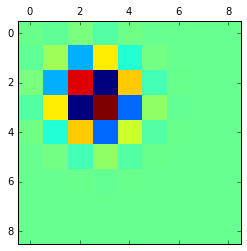

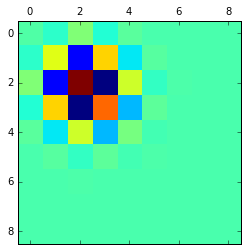

In [11]:
plt.matshow(pcov) # plot covariance matrix to show goodness of fit"
plt.matshow(pcov2)

### Reconstruction from Cyril decomposition

In [12]:
CTfit=CTpoly(fitcoefs,alphas,nu0,freq)  # full data
CTfit2=CTpoly(fitcoefs2,alphas,nu0,freq) # sampled fata

##### Full dataset

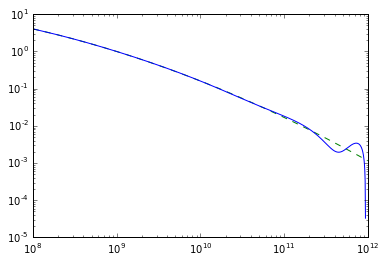

In [13]:
plt.loglog(freq,spectrum2,"g--",ms=0.5)
plt.loglog(freq,CTfit)

##### Sampled dataset

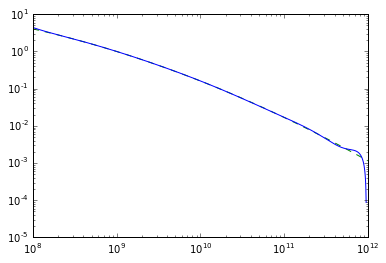

In [14]:
plt.loglog(freq,spectrum2,"g--",ms=0.5)
plt.loglog(freq,CTfit2)

##### I do not know how Cyril performs the fitting to get the coefficients, but weird behavior at high frequencies (must be numerical errors as its changes everytime I restart and rerun the whole python notebook...)
##### How to link the $\alpha_i$ to the physical $\alpha$ and $\beta$ of the source?

### Plotting individual basis spectrum weighted by their respective coefficient (full dataset only)

min= 1.8383324816e-08 max= 1.8383324816
min= -5.17941633689 max= -5.17941633689e-06
min= 0.000488353772511 max= 4.88353772511
min= 0.0273666505357 max= 2.73666505357
min= -0.240684560382 max= -0.240684560382
min= 0.0104279205653 max= 1.04279205653
min= -2.26625032518 max= -0.000226625032518
min= 2.32242889861e-06 max= 2.32242889861
min= -0.888912339722 max= -8.88912339722e-09


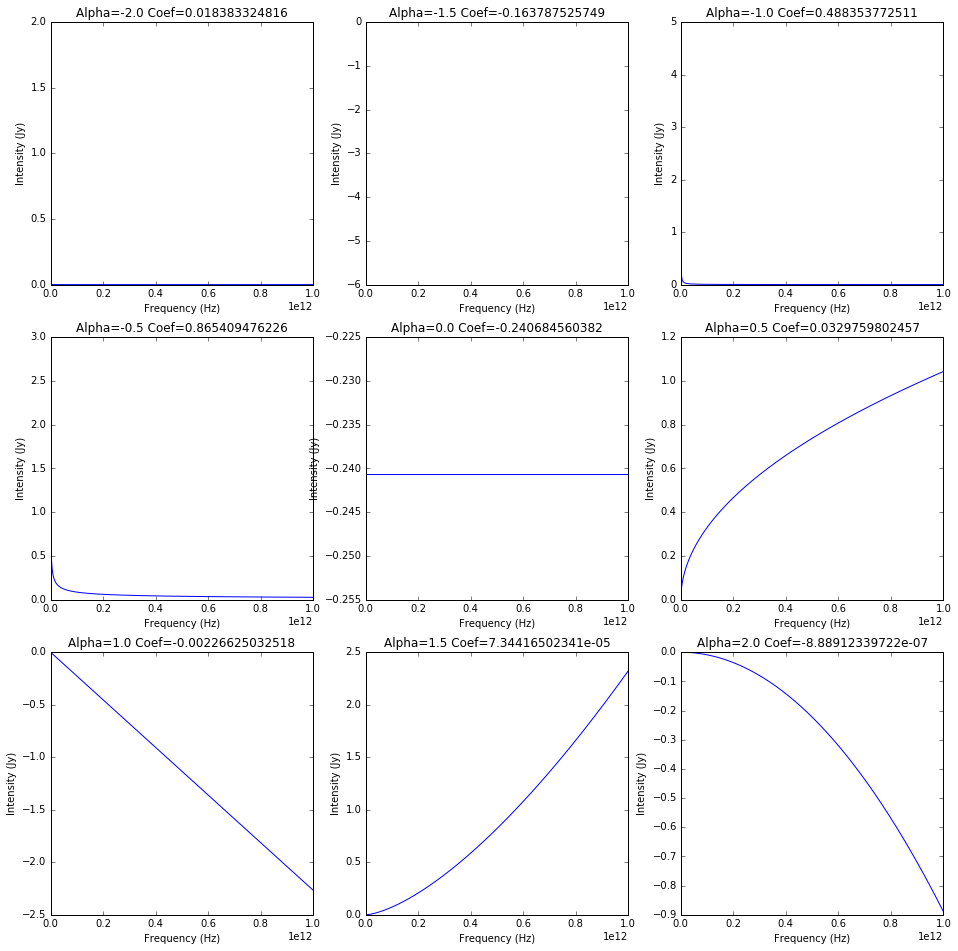

In [15]:
rows=3
ncols=3
plt.figure(figsize=(16,16))
for i in np.arange(len(alphas)):
    alphas
    basisspectrum=fitcoefs[0][i]*(freq*1./nu0)**(alphas[i])
    print "min=",basisspectrum.min(),"max=",basisspectrum.max()
    plt.subplot2grid((rows,ncols), (i//ncols,i%ncols))
    title='Alpha='+str(alphas[i])+" Coef="+str(fitcoefs[0][i])
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Intensity (Jy)')

    plt.plot(freq,basisspectrum) 

In [16]:
fitcoefs

[array([  1.83833248e-02,  -1.63787526e-01,   4.88353773e-01,
          8.65409476e-01,  -2.40684560e-01,   3.29759802e-02,
         -2.26625033e-03,   7.34416502e-05,  -8.88912340e-07])]